In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, 4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616))
])

In [4]:
train_dataset = datasets.CIFAR10("./data", train = True, transform = train_transform, download = True)
test_dataset = datasets.CIFAR10("./data", train = False, transform = test_transform, download = True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle = True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle = False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride = 1, padding=1, bias = False),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #self.maxpool = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [8]:
num_epochs = 100
learning_rate = 0.1

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay=5e-4, momentum = 0.9)

In [9]:
warmup_epochs = 5

scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)

scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler1, scheduler2],
    milestones = [warmup_epochs]
)

In [10]:
train_losses = []
test_accuracies = []
best_acc = 0.0
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()

        
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct/total
    test_accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_cifar_resnet.pth')
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {acc:.2f}% [NEW RECORD! Saved]")
    else:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")

print(f"\nTraining done, the best model had the accuracy: {best_acc:.2f}%")


Epoch 1 | Loss: 1.9366 | Acc: 49.82% [NEW RECORD! Saved]
Epoch 2 | Loss: 1.8204 | Acc: 54.81% [NEW RECORD! Saved]
Epoch 3 | Loss: 1.6629 | Acc: 57.92% [NEW RECORD! Saved]
Epoch 4 | Loss: 1.5546 | Acc: 59.97% [NEW RECORD! Saved]


c:\Users\aditu\miniconda3\envs\plant_disease\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5 | Loss: 1.4647 | Acc: 67.80% [NEW RECORD! Saved]
Epoch 6 | Loss: 1.3881 | Acc: 71.18% [NEW RECORD! Saved]
Epoch 7 | Loss: 1.2990 | Acc: 73.21% [NEW RECORD! Saved]
Epoch 8 | Loss: 1.2437 | Acc: 75.95% [NEW RECORD! Saved]
Epoch 9 | Loss: 1.2003 | Acc: 73.26%
Epoch 10 | Loss: 1.1661 | Acc: 76.66% [NEW RECORD! Saved]
Epoch 11 | Loss: 1.1460 | Acc: 75.67%
Epoch 12 | Loss: 1.1391 | Acc: 78.64% [NEW RECORD! Saved]
Epoch 13 | Loss: 1.1199 | Acc: 79.76% [NEW RECORD! Saved]
Epoch 14 | Loss: 1.1141 | Acc: 79.27%
Epoch 15 | Loss: 1.0950 | Acc: 78.96%
Epoch 16 | Loss: 1.0831 | Acc: 80.98% [NEW RECORD! Saved]
Epoch 17 | Loss: 1.0747 | Acc: 79.04%
Epoch 18 | Loss: 1.0634 | Acc: 81.34% [NEW RECORD! Saved]
Epoch 19 | Loss: 1.0680 | Acc: 81.79% [NEW RECORD! Saved]
Epoch 20 | Loss: 1.0553 | Acc: 82.23% [NEW RECORD! Saved]
Epoch 21 | Loss: 1.0621 | Acc: 82.00%
Epoch 22 | Loss: 1.0440 | Acc: 81.26%
Epoch 23 | Loss: 1.0495 | Acc: 78.94%
Epoch 24 | Loss: 1.0433 | Acc: 82.91% [NEW RECORD! Saved]
Epoch

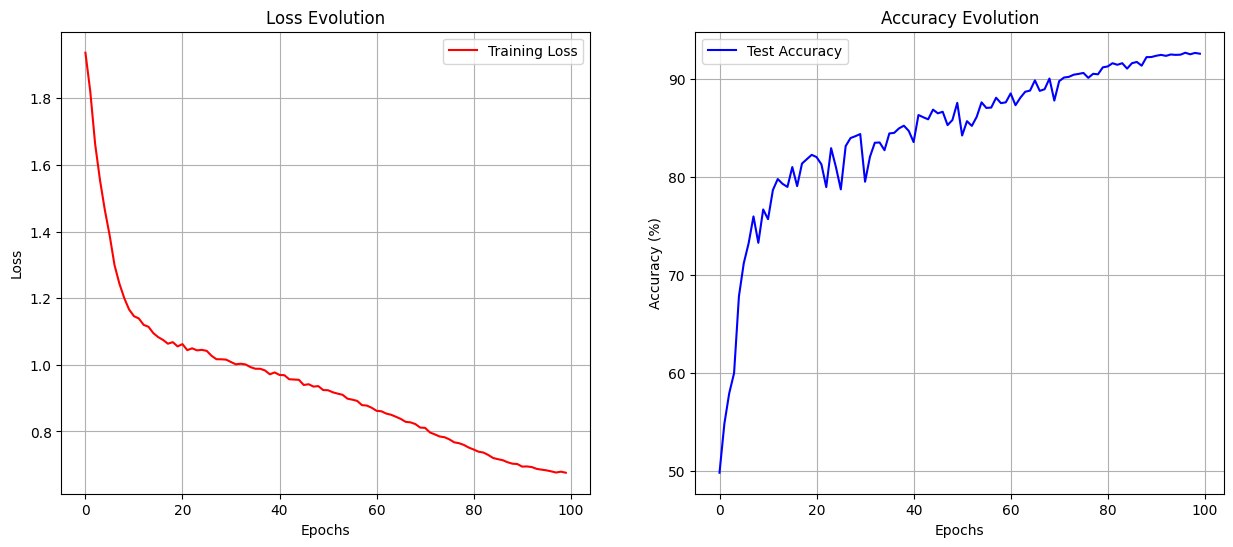

In [14]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(train_losses, label = "Training Loss", color = 'red')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label = "Test Accuracy", color = 'blue')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.show()